
#  Feature Selection Wrapper Methods

#### Eric Hu
#### Walker Department of Mechanical Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Elnara Rustamzade, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade/)


## Executive Summary

This projects presents an opportunity to examine different wrapper functions for feature importance and ranking that have been extensively used in many research topics. To address this examination, we performed regression analyses using a basic linear regression model and comparing the model performance with the same regressor method using the following techniques: Exhaustive Feature Selection, Forward Feature Selection, and Backward Feature Elimination. From the results of this workflow, we found that each technique has differences in feature ranking, but maintained similar model performance when only capturing the top three features from each ranking. Future analyses with this data should take into consideration the biases in each technique as well as multicolinearity within the data when deciding which regressor and feature importance wrapper technique to use.

### Import Packages

In [4]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
from sklearn import preprocessing                             # remove encoding error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression             # linear regression model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.utils import resample
from collections import Counter
from mlxtend.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter) # control of axes ticks
import seaborn as sns                                         # for matrix scatter plots

### Functions For Plotting

The following functions will be used in the workflow.

Both functions are from Professor Michael Pyrcz (@GeostatsGuy), https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_knearest_neighbours.html

In [6]:
def comma_format(x, pos):  #formatting plots with this format type
    return f'{int(x):,}'

def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

## Feature Selection Workflow Summary

This work flow will go through the following steps to ....

1. Data Loading and Formatting
2. Check for Missing Data
3. Train-Test Split and Standardization of the Data
4. Initial Linear Regression
5. Exhaustive Feature Selection
6. Forward Feature Selection
7. Backward Feature Elimintation
8. Results Summary

After this workflow, we can effectively compare the three wrapper methods of feature selection. We expect that each technique will produce a different feature ranking due to the differences in methodology.

### 1. Data Loading and Formatting

The following workflow applies the .csv file 'unconv_MV_v5.csv', a synthetic dataset of variables listed below from 1,000 unconventional wells. The dataset is publically available [here](https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV.csv)  

We will work with the following features:

**Predictor Features:**
* **porosity** - fraction of rock void in units of percentage
* **permeability** - ability of a fluid to flow through the rock in mil;iDarcy
* **acoustic impedence** - product of sonic velocity and rock density in unitsof $kg/m^2s*10^3$
* **Brittleness** -  in units of percentage
* **Total Organic Carbon (TOC)** - ability of a fluid to flow through the rock in mil;iDarcy
* **Vitrinite Reflectance (VR)** - in units of percentage

**Response Feature:**
* **Production** - initial 90 average of production in MCFPD

The following code block is adapted from Professor Michael Pyrcz (@GeostatsGuy), https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_feature_ranking.html. Changes made were only to include necessary code.


In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v5.csv') # load data from Dr. Pyrcz's GitHub repository  

# specify the response feature
response = 'Prod'                                             

# Add noise to the dataset 
add_noise = True                                      
noise_stdev = 500                                             
seed =13
np.random.seed(seed = seed)                                   # set the random number seed
if add_noise == True:
    df[response] = df[response] + np.random.normal(loc=0.0,scale=noise_stdev,size = len(df))

#Separate the data to predictor and response features
x = df.copy(deep = True); x = x.drop(['Well',response],axis='columns') # make predictor and response DataFrames
Y = df.loc[:,response]

features = x.columns.values.tolist() + [Y.name]               # store the names of the features
pred = x.columns.values.tolist()
resp = Y.name

#Set the ranges of each feature for plotting and scaling purposes
xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; xmax = [24.0,10.0,5.0,85.0,2.2,2.9] 
ymin = 500.0; ymax = 9000.0

#Create labels of the feature names and units
predlabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', 
             'Total Organic Carbon (%)','Vitrinite Reflectance (%)']
resplabel = 'Normalized Initial Production (MCFPD)'

predtitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', 
             'Total Organic Carbon','Vitrinite Reflectance']
resptitle = 'Normalized Initial Production'



### 2. Check for Missing Values

Before analyzing the data, we must check if there are any missing values within the dataset. Missing values can produce errors when using functions and produce misleading conclusion about the sample or the population.

The block below checks if any of the features have "null" values from the dataset and plots the number of null values, if any, as a bar graph.

The following code block is adapted from Professor Michael Pyrcz (@GeostatsGuy), https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_feature_ranking.html.


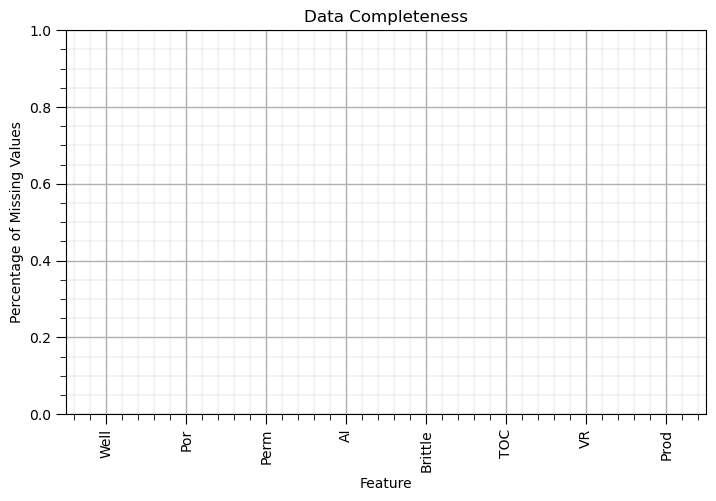

In [11]:
df.describe().transpose()                                     # calculate summary statistics for the data
plt.subplot(111)
(df.isnull().sum()/len(df)).plot(kind = 'bar')                # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); add_grid(); plt.show()

From this graph, we can see that the data that we are using contains no missing values and we can move on.

If missing values are present, then feature imputation methods are needed as a subsequent step to have a near complete dataset.


### 3. Train-Test Split and Standardization

- In this step, the data will be first split into testing and training data using the scikit learn **train_test_split()** function. The chosen allocation of testing data is 20% of the entire data set with a random state is 73073. 

- Once this step is completed, the predictor features and the response feature are standardardize by **StandardScaler()** function, This process is done so that the range of units between the feature do not skew the analysis when performing the feature selection methods.

- After both processes, a subplot of the standardized train-test split are provided as overlaid histograms of each other.

This code adapted from Professor Michael Pyrcz, https://geostatsguy.github.io/MachineLearningDemos_Book/MachineLearning_knearest_neighbours.html

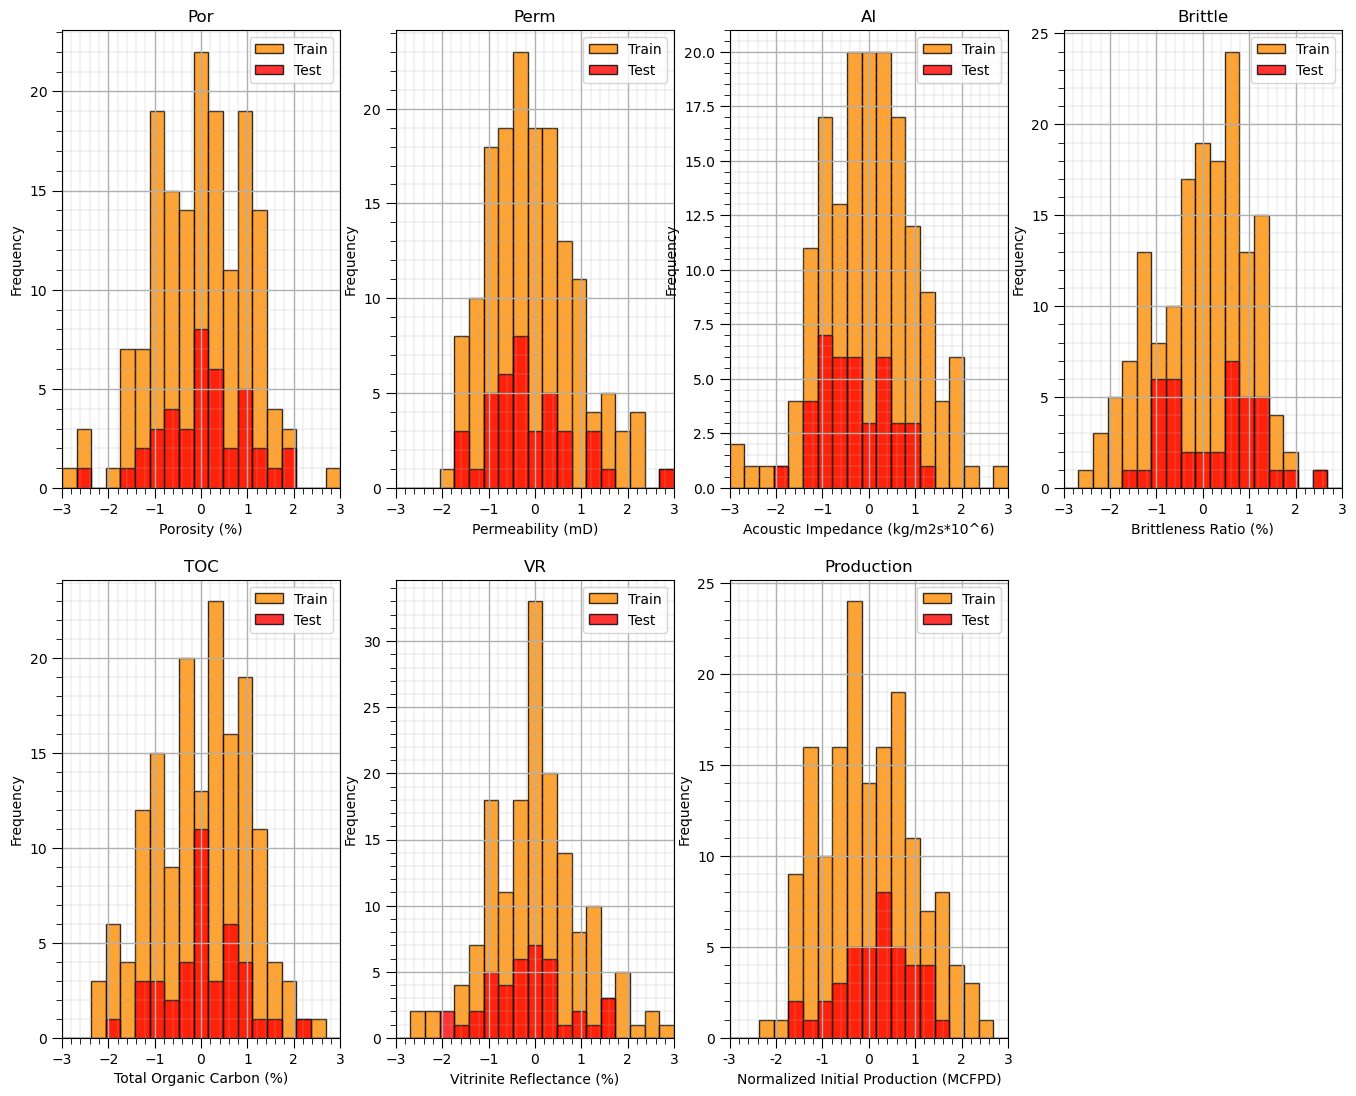

In [14]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,pred],df.loc[:,resp],test_size=0.2,random_state=73073)

transform = StandardScaler();  
X_train_std = transform.fit_transform(X_train)
X_test_std = transform.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


#Histogram of the train test split: 
nbins = 20                                                    # number of histogram bins

plt.subplot(241)
plt.hist(X_train_std[:,0],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test_std[:,0],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(pred[0]); plt.xlim(-3,3); plt.xlabel(predlabel[0]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(242)
plt.hist(X_train_std[:,1],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test_std[:,1],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(pred[1]); plt.xlim(-3,3); plt.xlabel(predlabel[1]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(243)
plt.hist(X_train_std[:,2],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test_std[:,2],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(pred[2]);plt.xlim(-3,3); plt.xlabel(predlabel[2]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(244)
plt.hist(X_train_std[:,3],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test_std[:,3],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(pred[3]); plt.xlim(-3,3); plt.xlabel(predlabel[3]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(245)
plt.hist(X_train_std[:,4],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test_std[:,4],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(pred[4]); plt.xlim(-3,3); plt.xlabel(predlabel[4]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(246)
plt.hist(X_train_std[:,5],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(X_test_std[:,5],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.title(pred[5]); plt.xlim(-3,3); plt.xlabel(predlabel[5]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(247)
plt.hist(y_train_scaled,alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Train')
plt.hist(y_test_scaled,alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,3,nbins),label='Test')
plt.legend(loc='upper right'); plt.title('Production'); plt.xlim(-3,3) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
plt.xlabel(resplabel); plt.ylabel('Frequency'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()


From these plots, we can see that the testing data chosen provides about complete coverage of the respective parameter and that all features were correctly standardized. 

### 4. Perform Initial Multilinear Regression

- Next is to create a linear regression model that relates all 6 predictor features to the response feature. This will serve as a baseline to compare the results of the other models to.
    
- We begin by fitting the linear regression model with the training data of both the predictor and response features. Then both the training and testing data were used to predict the response feature of the respective inputs. Typically, only the testing data should be inputted when predicting, but the response using the training data was also predicted to just give a baseline to compare the testing data to. 


In [17]:
model = LinearRegression()
model.fit(X_train_std, y_train_scaled)
y_train_pred = model.predict(X_train_std)
y_test_pred = model.predict(X_test_std)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print()

print("Final Model Performance: ")
print(f"Train R²: {r2_score(y_train_scaled, y_train_pred):.4f}")
print(f"Test R²:  {r2_score(y_test_scaled, y_test_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train_scaled, y_train_pred):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test_scaled, y_test_pred):.4f}")

Coefficients: [ 0.70405894  0.14360675 -0.25779281  0.26594344 -0.12616525  0.26444088]
Intercept: -1.2160843741645705e-15

Final Model Performance: 
Train R²: 0.8013
Test R²:  0.6917
Train MSE: 0.1987
Test MSE:  0.1947


After fitting, the coefficients and intercepts of the linear regression model as well as the coefficient of determination (r^2) and the mean squared error (MSE) are printed for comparison.

### 5. Exhaustive Feature Selection

- The first feature selection wrapper method is Exhaustive Feature Selection (EFS). Exhaustive feature selection is a brute-force technique used to find the best combination of features for a model by trying every possible subset of the features from a prescribed range of the number of features and evaluating model performance for each one. 
    
- The EFS process is performed using the EFS function in the mlxtend imported library called EFS(). For this purpose, I will pass in the following variables to the function:
        
        1. estimator -> Scikit Learn Classifier or Regressor (Linear Regression model in this example) 
        2. min_features -> minimum number of features to select (1)
        3. max_features -> maximum number of features to select (6)
        4. scoring -> scoring metric for estimator (mean squared error)
        5. cv -> cross validation generator with k-folds (5)
        
    
- In our example, we introduce bootstrapping as well. Bootstrapping is a resampling technique used to estimate the distribution of a statistic by randomly sampling with replacement from your original dataset. In this case, bootstrap was used on the training data after a set number of bootstrap iterations to produce the list of best features that are selected from EFS. The bootstrap method is run using a for loop across the number of bootstrap iterations and the **resample()** method that choose a sample with replacement that is used in the EFS function.
    
- Once the number of bootstrap iterations is complete, the feature occurence frequency is tabulated and plotted in a bar chart.

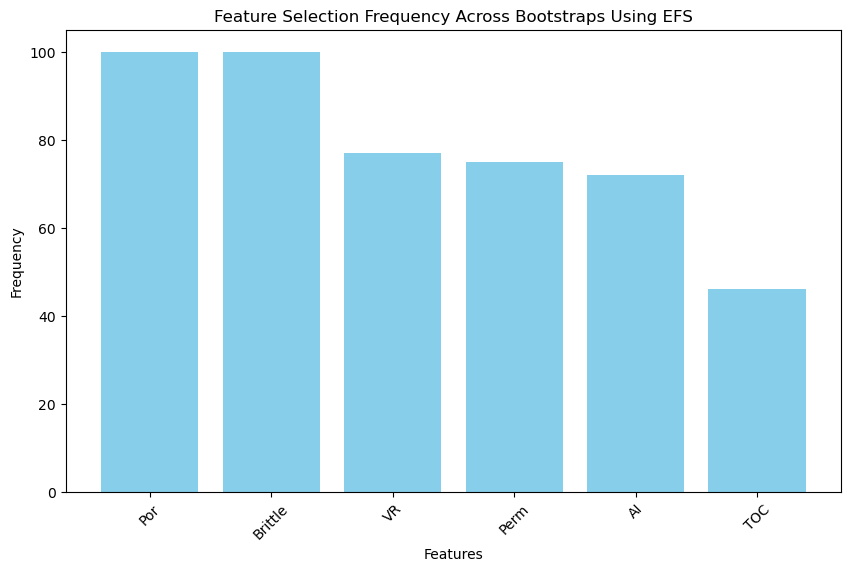


 Feature Selection Stability (Bootstrap Results):
Feature Por selected 100/100 times
Feature Brittle selected 100/100 times
Feature VR selected 77/100 times
Feature Perm selected 75/100 times
Feature AI selected 72/100 times
Feature TOC selected 46/100 times


In [21]:
num_bootstrap_samples = 100  # Number of bootstrap samples
efs_selected_features_list = []  # Store selected features from each bootstrap iteration

for i in range(num_bootstrap_samples):
    # Bootstrap sampling (with replacement)
    X_resampled, y_resampled = resample(X_train_std, y_train_scaled, random_state=i)

    # Apply EFS
    efs = EFS(
        model,
        min_features=1,
        max_features=X_resampled.shape[1],
        scoring='neg_mean_squared_error',
        print_progress=False,
        cv=5
    )
    efs.fit(X_resampled, y_resampled)

    # Store selected features from this bootstrap iteration
    efs_selected_features_list.append(tuple(efs.best_idx_))

# Count feature selection frequency
efs_feature_counts = Counter([feature for subset in efs_selected_features_list for feature in subset])
efs_sorted_features = sorted(efs_feature_counts.items(), key=lambda x: x[1], reverse=True)
sortednamesefs =[]
for feature_idx, count in efs_sorted_features:
    sortednamesefs.append(df.loc[:,pred].columns[feature_idx])
# print(sortednames)
# Create a histogram of feature selection frequencies
# feature_names =df.loc[:,pred].columns
efs_frequencies = [count for _, count in efs_sorted_features]

plt.figure(figsize=(10, 6))
plt.bar(sortednamesefs, efs_frequencies, color='skyblue')
plt.title('Feature Selection Frequency Across Bootstraps Using EFS')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# Print Results
print("\n Feature Selection Stability (Bootstrap Results):")
for feature_idx, count in efs_sorted_features:
    print(f"Feature {df.loc[:,pred].columns[feature_idx]} selected {count}/{num_bootstrap_samples} times")

#### Linear Regression After EFS
    After figuring out what the top features are through EFS, we predicted the response using the linear regression model with the top three features to see any changes in our statistic. We will consolidate and summarize the results in the final portion of this workflow.

In [23]:
# Select the most frequently chosen features
efs_top_features_indices = [feat[0] for feat in efs_sorted_features[:3]]  # Select top 3 most frequent features

# Train model on selected features
X_train_best_efs = X_train_std[:, efs_top_features_indices]
X_test_best_efs = X_test_std[:, efs_top_features_indices]

model.fit(X_train_best_efs, y_train_scaled)
y_train_pred_best_efs = model.predict(X_train_best_efs)
y_test_pred_best_efs = model.predict(X_test_best_efs)

print()
print(" Final Model Performance After Bootstrapped EFS:")
print(f"Train R²: {r2_score(y_train_scaled, y_train_pred_best_efs):.4f}")
print(f"Test R²:  {r2_score(y_test_scaled, y_test_pred_best_efs):.4f}")
print(f"Train MSE: {mean_squared_error(y_train_scaled, y_train_pred_best_efs):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test_scaled, y_test_pred_best_efs):.4f}")


 Final Model Performance After Bootstrapped EFS:
Train R²: 0.7878
Test R²:  0.6581
Train MSE: 0.2122
Test MSE:  0.2159


### 6. Forward Feature Selection

- The second feature selection wrapper method is Forward Feature Selection (FFS). Forward feature selection is a stepwise feature selection technique that starts with an empty set of features and progressively adds the feature that results in the greatest improvement in model performance at each step.

- The FFS process is performed using the Sequential Feature Selector function in the mlxtend imported library called SFS(). For this purpose, I will pass in the following variables to the function:
    
        1. estimator -> Scikit Learn Classifier or Regressor (Linear Regression model in this example) 
        2. k_features -> the number of features to select ('best' = the feature subset size with the best cross-validation performance)
        3. forward -> boolean of either forward feature selection or backward feature elimination ('forward' for this section)
        4. floating -> Adds a conditional exclusion/inclusion (false)
        5. scoring -> scoring metric for estimator (mean squared error)
        6. cv -> cross validation generator with k-folds (5)
        7. n_jobs -> number of cpus (-1 = all cpus)
        8. verbose -> level of logging information (0 for no logging)

- We will again use bootstrapping on the training data after a set number of bootstrap iterations to produce the list of best features that are selected from FFS. The bootstrap method is run using a for loop across the number of bootstrap iterations and the "resample" method that choose a sample with replacement that is used in the FFS function.

- Once the number of bootstrap iterations is complete, the feature occurence frequency is tabulated and plotted in a bar chart.

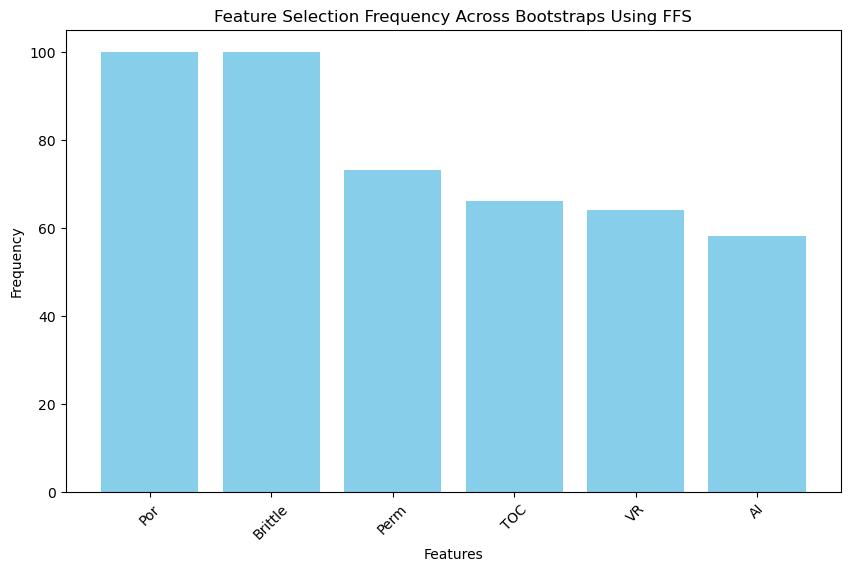


 Feature Selection Stability (Bootstrap Results):
Feature Por selected 100/100 times
Feature Brittle selected 100/100 times
Feature Perm selected 73/100 times
Feature TOC selected 66/100 times
Feature VR selected 64/100 times
Feature AI selected 58/100 times


In [26]:
model2 = LinearRegression()
model2.fit(X_train_std, y_train_scaled)
y_train_pred = model2.predict(X_train_std)
y_test_pred = model2.predict(X_test_std)

# Forward Feature Selection using mlxtend's SequentialFeatureSelector
ffs_selected_features_list = []  # Store selected features from each bootstrap iteration

for i in range(num_bootstrap_samples):
    # Bootstrap sampling (with replacement)
    X_resampled, y_resampled = resample(X_train_std, y_train_scaled, random_state=i)

    # Apply Sequential Feature Selection (SFS) with forward selection
    ffs = SFS(model2,
              k_features='best',  # Select the best k features
              forward=True,  # Forward selection
              floating=False,  # No floating feature search
              scoring='neg_mean_squared_error',  # Scoring method
              cv=5,  # Cross-validation folds
              n_jobs=-1,  # Parallel processing
              verbose=0)  # Silence progress printouts

    ffs.fit(X_resampled, y_resampled)

    # Store selected features from this bootstrap iteration
    ffs_selected_features_list.append(tuple(ffs.k_feature_idx_))

# Count feature selection frequency
ffs_feature_counts = Counter([feature for subset in ffs_selected_features_list for feature in subset])
ffs_sorted_features = sorted(ffs_feature_counts.items(), key=lambda x: x[1], reverse=True)
sortednamesffs =[]
for feature_idx, count in ffs_sorted_features:
    sortednamesffs.append(df.loc[:,pred].columns[feature_idx])
# Create a histogram of feature selection frequencies
ffs_frequencies = [count for _, count in ffs_sorted_features]

plt.figure(figsize=(10, 6))
plt.bar(sortednamesffs, ffs_frequencies, color='skyblue')
plt.title('Feature Selection Frequency Across Bootstraps Using FFS')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Print Results
print("\n Feature Selection Stability (Bootstrap Results):")
for feature_idx, count in ffs_sorted_features:
    print(f"Feature {df.loc[:,pred].columns[feature_idx]} selected {count}/{num_bootstrap_samples} times")


#### Linear Regression After FFS

    After figuring out what the top features are through FFS, we predicted the response using the linear regression model with the top three features to see any changes in our statistic. We will consolidate and summarize the results in the final portion of this workflow.

In [28]:
# Select the most frequently chosen features
ffs_top_features_indices = [feat[0] for feat in ffs_sorted_features[:3]]  # Select top 3 most frequent features

# Train model on selected features
ffs_X_train_best = X_train_std[:, ffs_top_features_indices]
ffs_X_test_best = X_test_std[:, ffs_top_features_indices]

model2.fit(ffs_X_train_best, y_train_scaled)
ffs_y_train_pred_best = model2.predict(ffs_X_train_best)
ffs_y_test_pred_best = model2.predict(ffs_X_test_best)

print()
print(" Final Model Performance After Bootstrapped FFS:")
print(f"Train R²: {r2_score(y_train_scaled, ffs_y_train_pred_best):.4f}")
print(f"Test R²:  {r2_score(y_test_scaled, ffs_y_test_pred_best):.4f}")
print(f"Train MSE: {mean_squared_error(y_train_scaled, ffs_y_train_pred_best):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test_scaled, ffs_y_test_pred_best):.4f}")


 Final Model Performance After Bootstrapped FFS:
Train R²: 0.7864
Test R²:  0.6884
Train MSE: 0.2136
Test MSE:  0.1967


### 7. Backward Feature Elimination

- The third feature selection wrapper method is Backward Feature Elimination (BFE). Backward Feature Elimination is a stepwise feature selection technique that starts with all available features and iteratively removes the least significant feature at each step. 

- The BFE process is performed using the Sequential Feature Selector function in the mlxtend imported library called SFS(). For this purpose, I will pass in the following variables to the function:
    
        1. estimator -> Scikit Learn Classifier or Regressor (Linear Regression model in this example) 
        2. k_features -> the number of features to select ('best' = the feature subset size with the best cross-validation performance)
        3. forward -> boolean of either forward feature selection or backward feature elimination ('backward' for this section)
        4. floating -> Adds a conditional exclusion/inclusion (false)
        5. scoring -> scoring metric for estimator (mean squared error)
        6. cv -> cross validation generator with k-folds (5)
        7. n_jobs -> number of cpus (-1 = all cpus)
        8. verbose -> level of logging information (0 for no logging)

- We will again use bootstrapping on the training data after a set number of bootstrap iterations to produce the list of best features that are selected from BFE. The bootstrap method is run using a for loop across the number of bootstrap iterations and the "resample" method that choose a sample with replacement that is used in the BFE function.

- Once the number of bootstrap iterations is complete, the feature occurence frequency is tabulated and plotted in a bar chart.

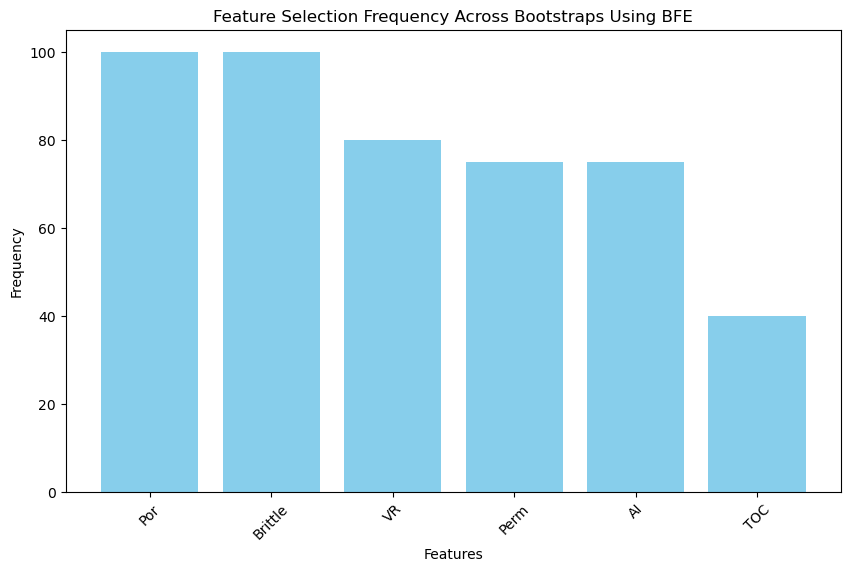


 Feature Selection Stability (Bootstrap Results):
Feature Por selected 100/100 times
Feature Brittle selected 100/100 times
Feature VR selected 80/100 times
Feature Perm selected 75/100 times
Feature AI selected 75/100 times
Feature TOC selected 40/100 times


In [31]:
# Backward Feature Elimination using mlxtend's SequentialFeatureSelector
model3 = LinearRegression()
model3.fit(X_train_std, y_train_scaled)
y_train_pred = model3.predict(X_train_std)
y_test_pred = model3.predict(X_test_std)
bfe_selected_features_list = []  # Store selected features from each bootstrap iteration

for i in range(num_bootstrap_samples):
    # Bootstrap sampling (with replacement)
    X_resampled, y_resampled = resample(X_train_std, y_train_scaled, random_state=i)

    # Apply Sequential Feature Selection (SFS) with forward selection
    bfe = SFS(model3,
              k_features='best',  # Select the best k features
              forward=False,  # Forward selection
              floating=False,  # No floating feature search
              scoring='neg_mean_squared_error',  # Scoring method
              cv=5,  # Cross-validation folds
              n_jobs=-1,  # Parallel processing
              verbose=0)  # Silence progress printouts

    bfe.fit(X_resampled, y_resampled)

    # Store selected features from this bootstrap iteration
    bfe_selected_features_list.append(tuple(bfe.k_feature_idx_))

# Count feature selection frequency
bfe_feature_counts = Counter([feature for subset in bfe_selected_features_list for feature in subset])
bfe_sorted_features = sorted(bfe_feature_counts.items(), key=lambda x: x[1], reverse=True)
sortednamesbfe =[]
for feature_idx, count in bfe_sorted_features:
    sortednamesbfe.append(df.loc[:,pred].columns[feature_idx])
# Create a histogram of feature selection frequencies
bfe_frequencies = [count for _, count in bfe_sorted_features]

plt.figure(figsize=(10, 6))
plt.bar(sortednamesbfe, bfe_frequencies, color='skyblue')
plt.title('Feature Selection Frequency Across Bootstraps Using BFE')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Print Results
print("\n Feature Selection Stability (Bootstrap Results):")
for feature_idx, count in bfe_sorted_features:
    print(f"Feature {df.loc[:,pred].columns[feature_idx]} selected {count}/{num_bootstrap_samples} times")

#### Linear Regression After BFE

    After figuring out what the top features are through BFE, we predicted the response using the linear regression model with the top three features to see any changes in our statistic. We will consolidate and summarize the results in the final portion of this workflow.

In [33]:
# Select the most frequently chosen features
bfe_top_features_indices = [feat[0] for feat in bfe_sorted_features[:3]]  # Select top 3 most frequent features

# Train model on selected features
bfe_X_train_best = X_train_std[:, bfe_top_features_indices]
bfe_X_test_best = X_test_std[:, bfe_top_features_indices]

model3.fit(bfe_X_train_best, y_train_scaled)
bfe_y_train_pred_best = model3.predict(bfe_X_train_best)
bfe_y_test_pred_best = model3.predict(bfe_X_test_best)

print(" Final Model Performance After Bootstrapped FFS:")
print(f"Train R²: {r2_score(y_train_scaled, bfe_y_train_pred_best):.4f}")
print(f"Test R²:  {r2_score(y_test_scaled, bfe_y_test_pred_best):.4f}")
print(f"Train MSE: {mean_squared_error(y_train_scaled, bfe_y_train_pred_best):.4f}")
print(f"Test MSE:  {mean_squared_error(y_test_scaled, bfe_y_test_pred_best):.4f}")

 Final Model Performance After Bootstrapped FFS:
Train R²: 0.7878
Test R²:  0.6581
Train MSE: 0.2122
Test MSE:  0.2159


### Results Summary
    As a summary of the results, the feature selection frequency plots from each technique are plotted together and a table of the MSE and r^2 values of the training and testing data using each technique are provided. 

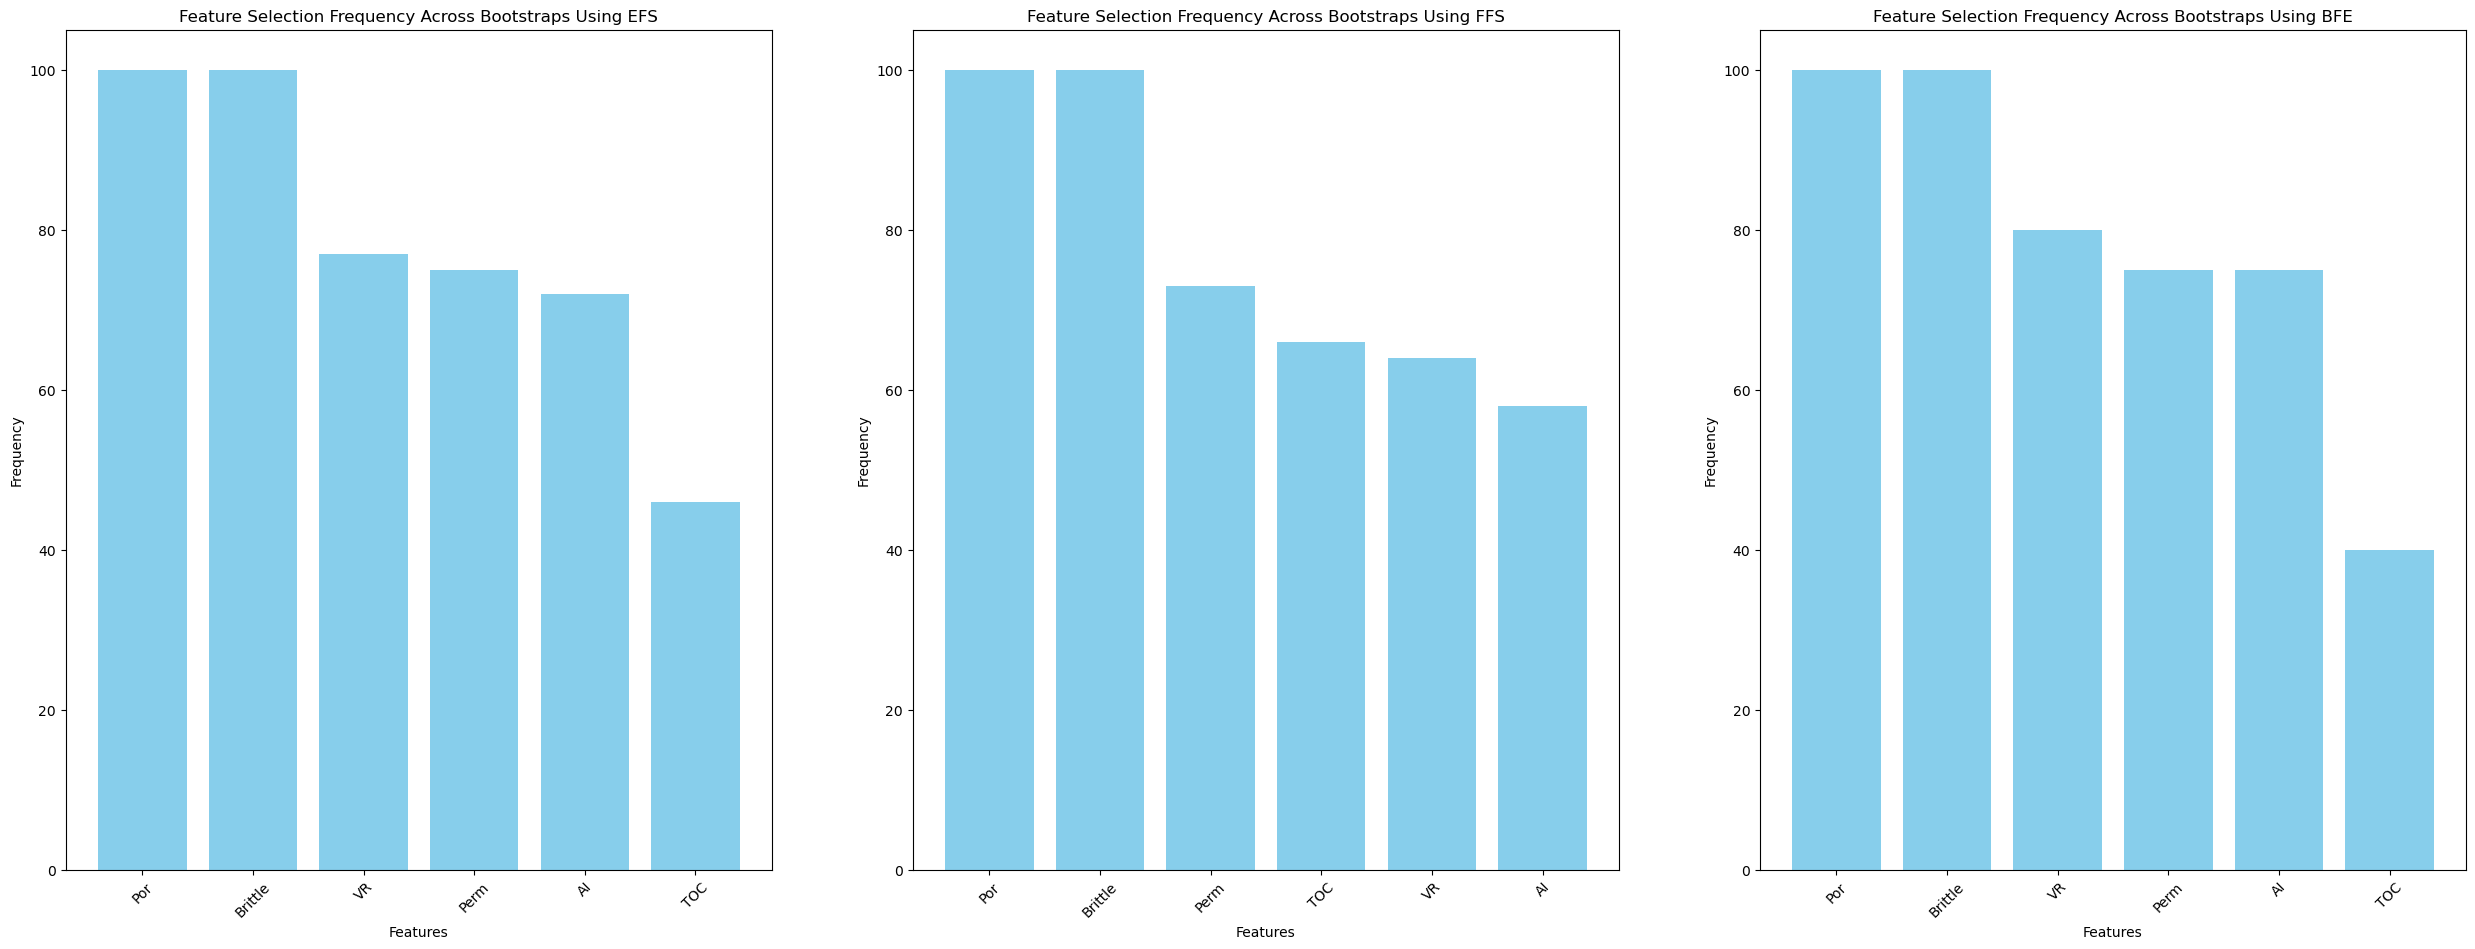

,Initial,EFS,FFS,BFE
R²,0.691680,0.658086,0.688446,0.658086
MSE,0.194665,0.215875,0.196707,0.215875


In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1,)

plt.bar(sortednamesefs, efs_frequencies, color='skyblue')
plt.title('Feature Selection Frequency Across Bootstraps Using EFS')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45)


plt.subplot(1,3,2)

plt.bar(sortednamesffs, ffs_frequencies, color='skyblue')
plt.title('Feature Selection Frequency Across Bootstraps Using FFS')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45)


plt.subplot(1,3,3)

plt.bar(sortednamesbfe, bfe_frequencies, color='skyblue')
plt.title('Feature Selection Frequency Across Bootstraps Using BFE')
plt.xlabel('Features')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

#Dataframe comparing the model performance
results_df = pd.DataFrame({
    'Initial': [r2_score(y_test_scaled, y_test_pred), mean_squared_error(y_test_scaled, y_test_pred)],
    'EFS': [r2_score(y_test_scaled, y_test_pred_best_efs),mean_squared_error(y_test_scaled, y_test_pred_best_efs)],
    'FFS': [r2_score(y_test_scaled, ffs_y_test_pred_best),mean_squared_error(y_test_scaled, ffs_y_test_pred_best)],
    'BFE': [r2_score(y_test_scaled, bfe_y_test_pred_best),mean_squared_error(y_test_scaled, bfe_y_test_pred_best)]
}, index=['R²', 'MSE'])
results_df.style.set_caption("Model Performance Comparison with Testing Data")


### Validation of the Variable Selection:
    As a validation step of our results to see if the order of importance is accurate, permutation importance was used. Permutation importance is a model-agnostic technique that tell you how much a model’s prediction performance drops when the values of a feature are randomly shuffled. The permutation_importance method was used from the skikit learn inspection library.

Feature importance based on mean squared error
Por        0.663502
Brittle    0.138419
AI         0.080900
TOC        0.045601
VR         0.029605
Perm       0.018706
dtype: float64


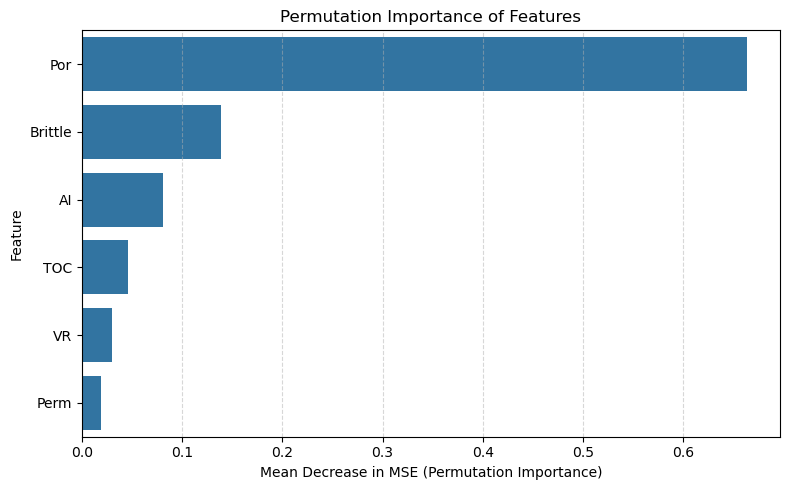

In [56]:
from sklearn.inspection import permutation_importance


model.fit(X_train_std, y_train_scaled)
result = permutation_importance(model, X_test_std, y_test_scaled, n_repeats=100,scoring='neg_mean_squared_error')

# Display most important features
importances = pd.Series(result.importances_mean, index= X_test.columns)
print("Feature importance based on mean squared error")
print(importances.sort_values(ascending=False))

# Sort for better plotting
importances_sorted = importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances_sorted, y=importances_sorted.index)

plt.xlabel("Mean Decrease in MSE (Permutation Importance)")
plt.ylabel("Feature")
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

#### Results Summary Points:
- From our results, the top two features selected from all methods are **Porosity** and **Brittleness**, but the third-most feature for the FFS technique was selected as permeability instead of VR. The frequency of selected features from the third-most to the sixth-most important feature is different between techniques as well.
    - These results partially supports the expectation made in the beginning of the workflow as there are differences in the frequency of selected features between the techniques but the ranking of features between EFS and BFE are the same.

      
- In all three cases, we can see that the r^2 values are similar to the initial linear regression model, suggesting that the models are able to explain the same amount of variance in the data with just a reduced number of features and eliminating redundant features.
  
- When comparing MSE, all three models were not able to improve the error from the model. Further, when we compare the model results to a model agnostic technique, we find that the top two features are the same but third-most feature to the sixth most feature has a different ranking. 
    - This may suggest that there is multicolinearity across the features that may not be captured by the wrapper functions and that bias from the wrapper function when selecting features may be introduced as well.

Overall, we can see that the methods are different in terms the frequency of selected features in the order of importance that they produce. Further research should examine multicolinearity within the dataset by using a different estimator regressor and uses of these wrapper functions should be carefully considered given the bias introduced by how the model selects the features.

### About the Workflow Author

Eric Hu is a Ph.D. student at The University of Texas at Austin studying Mechanical Engineering with an area of focus in Biomechanical Engineering. His research analyzes gait performance for individuals with a lower limb amputation during various ambulatory activities. He hopes to find solutions to improve different aspects of gait performance and overall quality of life for this population.

To find out more about Eric and his work, please visit his LinkedIn profile [here](https://www.linkedin.com/in/ehu1/).

#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).
